# Introduction to Setting Up the Environment and Importing Data
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalizing Environments
Let's try to unify the Google Colab environment and the local environment.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/01_02_data_import.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/01_02_data_import.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
%load_ext autoreload
%autoreload 2

If you are running on Google Colab, then in the next cell you'll be presented
with a widget. Use it to browse to the kaggle.json file.
(Note: You might have to show hidden files/folders in the file browser) 
It will also clone the workshop repository and change into its directory.

If you are running locally then this will simply change to the workshop root directory.

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.cwd() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
        # Download the workshop repo and change to its directory
        # For now edit the username/password. This requirement will be removed when the repo is made public.
        !git clone https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    IN_COLAB = False

Saving kaggle.json to kaggle.json
Cloning into 'IntracranialNeurophysDL'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 789 (delta 53), reused 46 (delta 21), pack-reused 683
Receiving objects: 100% (789/789), 24.97 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (451/451), done.


## Get Data

### Download
Now that your system is configured to use kaggle, whether local or running on colab,
we check for the existence of the datadir, and if it's not there we download the data
(2.2 GB) and unzip it into the correct folder.

While running on google colab, this takes about a minute to download and another minute to unzip.

While running locally, this can take a long time depending on your internet connection. The
PyCharm notebook interface doesn't give feedback about download or unzip status, so you may
want to download and extract from an Anaconda prompt, in the repository parent directory:
```
kaggle datasets download --unzip --path data/kjm_ecog/converted/faces_basic cboulay/kjm-ecog-faces-basic
```

If you are getting errors related to access restriction then you may need to download a new Kaggle API token and reset your Colab instance to upload the new .json file.

In [8]:
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")

100% 2.24G/2.24G [00:39<00:00, 30.8MB/s]
100% 2.24G/2.24G [00:39<00:00, 61.3MB/s]
Finished downloading and extracting data.


### Import File
We can now start working with the data.
We will import a single file that contains processed band-power data.

If you are curious about how the data were processed, the script can be found [here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/kjm_ecog/03_convert.py).

In [0]:
SUB_ID = 'de'
from data.utils.fileio import from_neuropype_h5
test_file = datadir / 'converted' / 'faces_basic' / (SUB_ID + '_bp.h5')
chunks = from_neuropype_h5(test_file)

## Data Exploration
### Print Contents
Let's quickly inspect the data to see what we have.

In [12]:
import pandas as pd

# Get the 'signals' chunk
chunk_names = [_[0] for _ in chunks]
chunk = chunks[chunk_names.index('signals')][1]
ax_types = [_['type'] for _ in chunk['axes']]

print("The 'signals' chunk has data with shape {}.".format(chunk['data'].shape))
print("The axes types are {}".format(ax_types))

time_axis = chunk['axes'][ax_types.index('time')]
t_vec = time_axis['times']
print("Each trial has {} samples, ranging from {} to {} s.".format(len(t_vec), min(t_vec), max(t_vec)))

instance_axis = chunk['axes'][ax_types.index('instance')]
print("The trial label frequencies are \n{}".format(pd.value_counts(instance_axis['data']['Marker'])))

The 'signals' chunk has data with shape (603, 17, 31).
The axes types are ['instance', 'time', 'space']
Each trial has 17 samples, ranging from -0.2 to 0.6 s.
The trial label frequencies are 
ISI      303
face     150
house    150
Name: Marker, dtype: int64


### Simple Plotting
The data contain 603 trials, with each trial having
17 samples in time, and 31 channels.
Of the 603 trials, 303 or inter-stimulus intervals, and the remaining
300 are split between `face` and `house`.

An N-dimensional data container is also called a "tensor".
The most common forms are 1-D tensors, also known as "vectors",
and 2-D tensors, also known as "matrices".

This is a 3-D tensor.

We will plot a few different slices of the tensor.

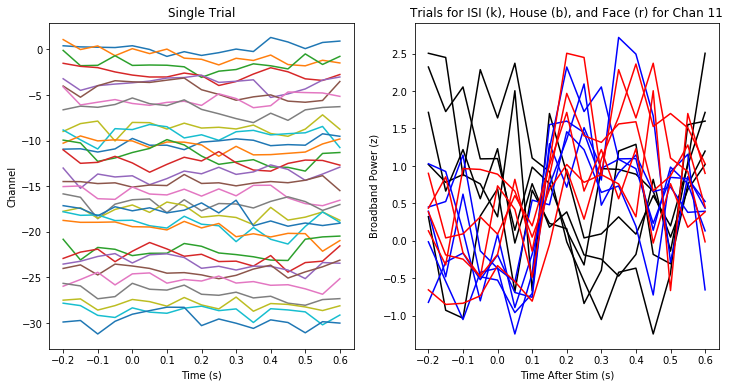

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), facecolor='white')

# Plot a single trial
tr_idx = 20  # trial index
dat = np.copy(chunk['data'][tr_idx, :, :])  # Slice a single-trial
dat -= np.arange(dat.shape[-1])[None, :]  # Separate channels for visibility.
plt.subplot(1, 2, 1)
plt.plot(t_vec, dat)
plt.title('Single Trial')
plt.ylabel('Channel')
plt.xlabel('Time (s)')

# Plot a few trials from a single channel.
ch_idx = 11  # Also try 22
dat = np.copy(chunk['data'][:, :, ch_idx])
tr_idx_isi = np.where(instance_axis['data']['Marker'] == 'ISI')[0][:5]
plt.subplot(1, 2, 2)
plt.plot(t_vec, dat[tr_idx_isi].T, 'k')
tr_idx_houses = np.where(instance_axis['data']['Marker'] == 'house')[0][:5]
plt.plot(t_vec, dat[tr_idx_houses].T, 'b')
tr_idx_faces = np.where(instance_axis['data']['Marker'] == 'face')[0][:5]
plt.plot(t_vec, dat[tr_idx_faces].T, 'r')
plt.title('Trials for ISI (k), House (b), and Face (r) for Chan {}'.format(ch_idx))
plt.ylabel('Broadband Power (z)')
plt.xlabel('Time After Stim (s)')

plt.show()

### Tensor Decomposition
Let's use a tensor-decomposition tool to get a simpler view of the tensor contents.
[Source](https://pyramidal.stanford.edu/publications/Williams2018_Neuron.pdf)
![simple linear network](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/tca.png?raw=1) 

In the below plot, each row is a different tensor component and each column is a different axis/dimension.
The output changes each time it is run.
Look for a component where the 1st column clearly shows two different groups of trials.
Then in the 2nd column we can see the time-course of that component, and in the 3rd column we see the channels that contributed to that component.

  Cloning https://github.com/ahwillia/tensortools to /tmp/pip-req-build-3fesgqzq
  Running command git clone -q https://github.com/ahwillia/tensortools /tmp/pip-req-build-3fesgqzq
  Stored in directory: /tmp/pip-ephem-wheel-cache-67et8bji/wheels/e4/4f/c6/b7ea145adb6874a9583dfe0c5c8ef3048335f4f885c6ee01ac
Successfully built tensortools
CP_ALS: iteration 1, objective 0.9841936591035372, improvement inf.
CP_ALS: iteration 2, objective 0.9394535621175045, improvement 0.04474009698603265.
CP_ALS: iteration 3, objective 0.926273055544752, improvement 0.013180506572752493.
CP_ALS: iteration 4, objective 0.9190449507203964, improvement 0.007228104824355652.
CP_ALS: iteration 5, objective 0.9171088123000862, improvement 0.0019361384203101517.
CP_ALS: iteration 6, objective 0.9168020647849953, improvement 0.000306747515090966.
CP_ALS: iteration 7, objective 0.916681288914409, improvement 0.00012077587058623163.
CP_ALS: iteration 8, objective 0.9165984689756899, improvement 8.28199387191697e-05.


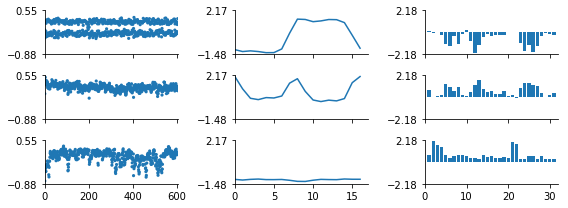

In [16]:
!pip install git+https://github.com/ahwillia/tensortools
import tensortools as tt
U = tt.cp_als(chunk['data'], rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'])

### Tensor Decomposition in Neuropype

The next cell does the same thing with a slightly better plot, but is for Neuropype users only,
and only those who have the latest version (should be out soon!).

As it uses plotly, it won't show up in PyCharm (should be fixed in v2019.2) but it will in a browser.

In [0]:
# Add my local copy of Neuropype to the PATH.
import sys
sys.path.append(str(Path.cwd().parent / 'Intheon' / 'cpe'))

In [0]:
import neuropype.nodes as nn
pkt = nn.ImportH5(filename=str(test_file))()
tt_res = nn.TensorDecomposition(num_components=3, aggregate_axes=['instance'])(
    data=pkt, return_outputs='all')
type_map = {'time': 'lines', 'space': 'bars', 'instance': 'markers'}
plt = nn.TensorDecompositionPlot(output_mode='notebook', iv_field='Marker',
                                 type_map=type_map)(data=tt_res['model'])